# Check making Fake Observation Data 




In [1]:
from spectrum_overload.Spectrum import Spectrum
from utilities.phoenix_utils import load_starfish_spectrum

from models.broadcasted_models import inherent_alpha_model

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

/home/jneal/anaconda3/envs/sims/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


[ 46516784.  46513112.  46506940. ...,  38149740.  38148884.  38146628.]
[ 2070.00411385  2070.01125086  2070.01838789 ...,  2179.98094066
  2179.98845685  2179.99597307]


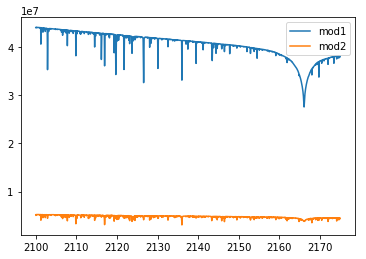

In [2]:
snr = 300
sim_num = 3
starname = "HDSIM3"
params1 = [7200, 4.0, 0.0]
params2 = [5500, 4.5, 0.5]
gamma = 20
rv = -40
#starname = "HDSIM2"
#params1 = [5000, 4.5, 0.0]
#params2 = [3500, 4.5, 0.0]
#gamma = 20
#rv = 4
normalization_limits = [2070, 2180]

mod1_spec = load_starfish_spectrum(params1, limits=normalization_limits,
                                       hdr=True, normalize=False, area_scale=True,
                                       flux_rescale=True)

mod2_spec = load_starfish_spectrum(params2, limits=normalization_limits,
                                       hdr=True, normalize=False, area_scale=True,
                                       flux_rescale=True)

print(mod1_spec.flux)
print(mod1_spec.xaxis)
mod1_spec = mod1_spec.remove_nans()
mod2_spec = mod2_spec.remove_nans()
mod1_spec.wav_select(2100, 2175)
mod2_spec.wav_select(2100, 2175)

plt.plot(mod1_spec.xaxis, mod1_spec.flux, label="mod1")
plt.plot(mod2_spec.xaxis, mod2_spec.flux, label="mod2")
plt.legend()
plt.show()


[ 2100.00208821  2100.00932865  2100.01656911 ...,  2174.9809093
  2174.98840825  2174.99590722]
[ nan  nan  nan ...,  nan  nan  nan]


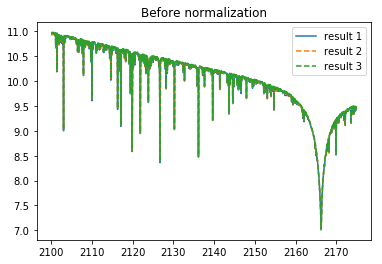

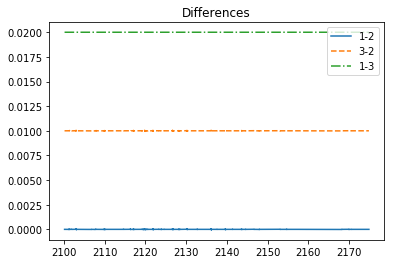

In [3]:
##################################
#broadcast = True
def join_with_broadcast(mod1, mod2, rv, gamma):
    broadcast_result = inherent_alpha_model(mod1.xaxis, mod1.flux, mod2.flux,
                                                rvs=rv, gammas=gamma)

    broadcast_values = broadcast_result(mod1.xaxis)
    return Spectrum(flux=broadcast_values.squeeze(), xaxis=mod1.xaxis)
    
##################################

# Manually redo the join
def join_with_spectrum_doppler(mod1, mod2, rv, gamma):
    mod2 = mod2.copy()
    mod2.doppler_shift(rv)
    mod2.interpolate1d_to(mod1.xaxis)
    combine = mod1.copy()
    combine += mod2
    combine.doppler_shift(gamma)
    combine.interpolate1d_to(mod1.xaxis)  # Interpolation was the key to the differnces
    return combine

###################################
# Manual shifts
def doppler(x, y, rv):
    x_new = (1 + rv / 299792.458) * x
    y_new = interp1d(x_new, y, axis=0, bounds_error=False)(x)
    return x, y_new

def join_with_manual_doppler(mod1, mod2, rv, gamma):
    mod2 = mod2.copy()
    x1, y1 = doppler(mod2.xaxis, mod2.flux, rv)
   
    combine = mod1.copy()
    combine += Spectrum(xaxis=x1, flux=y1)

    x2, y2 = doppler(combine.xaxis, combine.flux, gamma)

    return Spectrum(xaxis=x2, flux=y2)

####################################################
result1 = join_with_broadcast(mod1_spec, mod2_spec, rv, gamma)
result2 = join_with_spectrum_doppler(mod1_spec, mod2_spec, rv, gamma)
print(result2)
print(result2.xaxis)
print(result2.flux)
result3 = join_with_manual_doppler(mod1_spec, mod2_spec, rv, gamma)

plt.plot(result1.xaxis, result1.flux/4500000, label="result 1")
plt.plot(result2.xaxis, result2.flux/4500000 + 0.01, "--", label="result 2")
plt.plot(result3.xaxis, result3.flux/4500000 + 0.02, "--", label="result 3")
plt.title("Before normalization")
plt.legend()
plt.show()

plt.plot(result1.xaxis, result1.flux - result2.flux, label="1-2")
plt.plot(result1.xaxis, result3.flux - result2.flux + 0.01, "--", label="3-2")
plt.plot(result1.xaxis, result1.flux - result3.flux + 0.02, "-.", label="1-3")
plt.legend()
plt.title("Differences")
plt.show()



[ 0.  0.  0. ...,  0.  0.  0.]
False


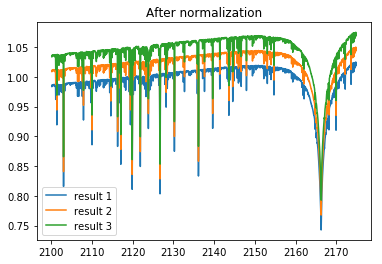

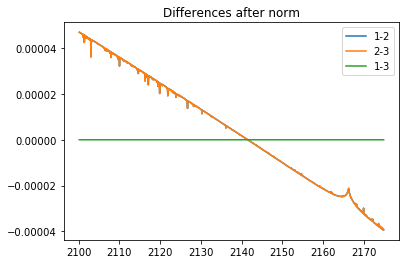

In [4]:

res1copy = result1.copy()

result1 = result1.remove_nans()
result2 = result2.remove_nans()
result3 = result3.remove_nans()
result3.interpolate1d_to(result1.xaxis)
print(result3.flux - result1.flux)
print(np.any(result3.flux - result1.flux))

result3 = result3.normalize(method="exponential")
result1 = result1.normalize(method="exponential")
result2 = result2.normalize(method="exponential")

plt.plot(result1.xaxis, result1.flux, label="result 1")
plt.plot(result2.xaxis, result2.flux + 0.025, label="result 2")
plt.plot(result3.xaxis, result3.flux + 0.05, label="result 3")
plt.title("After normalization")
plt.legend()
plt.show()

result1.interpolate1d_to(result1.xaxis)
result2.interpolate1d_to(result1.xaxis)
result3.interpolate1d_to(result1.xaxis)

plt.plot(result1.xaxis, result1.flux - result2.flux, label="1-2")
plt.plot(result1.xaxis, result3.flux - result2.flux, label="2-3")

plt.plot(result1.xaxis, result1.flux - result3.flux, label="1-3")
plt.legend()
plt.title("Differences after norm")
plt.show()

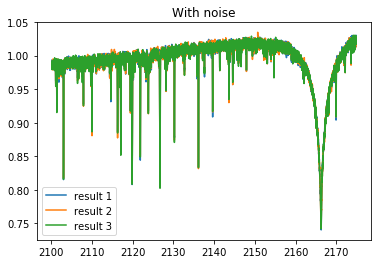

In [5]:
noise_res1 =  result1.copy()
noise_res3 =  result2.copy()
noise_res2 =  result3.copy()
noise_res1.add_noise(snr)
noise_res2.add_noise(snr)
noise_res3.add_noise(snr)

plt.plot(noise_res1.xaxis, noise_res1.flux, label="result 1")
plt.plot(noise_res2.xaxis, noise_res2.flux, label="result 2")
plt.plot(noise_res3.xaxis, noise_res3.flux, label="result 3")
plt.title("With noise")
plt.legend()
plt.show()


In [6]:

def export_fits(filename, wavelength, flux, hdr, hdrkeys, hdrvals):
    """Write Telluric Corrected spectra to a fits table file."""
    col1 = fits.Column(name="wavelength", format="E", array=wavelength)  # colums of data
    col2 = fits.Column(name="flux", format="E", array=flux)
    cols = fits.ColDefs([col1, col2])
   
    tbhdu = fits.BinTableHDU.from_columns(cols)  # binary tbale hdu
    prihdr = append_hdr(hdr, hdrkeys, hdrvals)
    prihdu = fits.PrimaryHDU(header=prihdr)
    thdulist = fits.HDUList([prihdu, tbhdu])
    
    thdulist.writeto(filename, output_verify="silentfix")   # Fixing errors to work properly
    return None

def append_hdr(hdr, keys=None, values=None, item=0):
    """Apend/change parameters to fits hdr.

    Can take list or tuple as input of keywords
    and values to change in the header
    Defaults at changing the header in the 0th item
    unless the number the index is givien,
    If a key is not found it adds it to the header.
    """
    if keys is not None and values is not None:
        if isinstance(keys, str):           # To handle single value
            hdr[keys] = values
        else:
            assert len(keys) == len(values), 'Not the same number of keys as values'
            for i, key in enumerate(keys):
                hdr[key] = values[i]
                # print(repr(hdr[-2:10]))
    return hdr

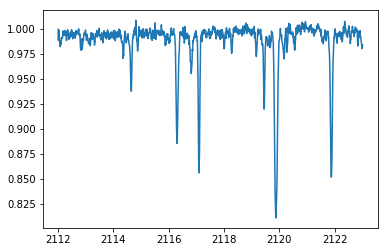

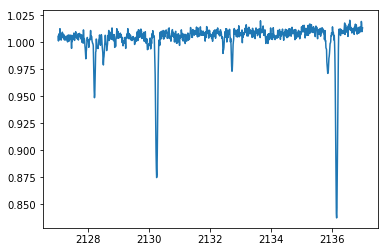

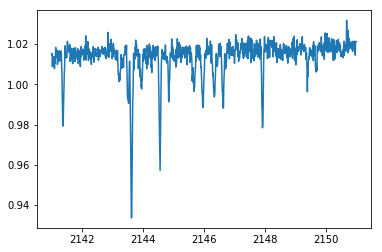

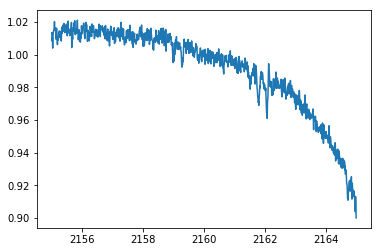

In [7]:
    from astropy.io import fits
    import os 
    import simulators
    # Detector limits
    dect_limits = [(2112, 2123), (2127, 2137), (2141, 2151), (2155, 2165)]
    npix = 1024
   

    header = fits.Header.fromkeys({})
    for ii, dect in enumerate(dect_limits):
        spec = result3.copy()
        spec.header = mod1_spec.header
        spec.wav_select(*dect)
        spec.interpolate1d_to(np.linspace(spec.xaxis[0], spec.xaxis[-1], npix))
                
        plt.plot(spec.xaxis, spec.flux)
        plt.show()
        name = "{0}-{1}-mixavg-tellcorr_{2}.fits".format(starname, sim_num, ii + 1)
        name = os.path.join(simulators.paths["spectra"], name)
        #spec.save...
        hdrkeys = ["Id_sim", "num", "snr"]
        hdrvals = ["Fake simulation data", sim_num, snr]
        if os.path.exists(name):
            print(name, "Already exists")
        else:
            export_fits(name, spec.xaxis, spec.flux, header, hdrkeys, hdrvals)